In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as st
import scipy.io as sio
from scipy.stats import f

# Load Data

In [2]:
data = sio.loadmat('552Final2021C.mat')
x = data['x552'].flatten()
y = data['y552'].flatten()
nn = len(x)

Data consists of red noise, an annual cycle, and some other harmonics.

# 1. Plot data

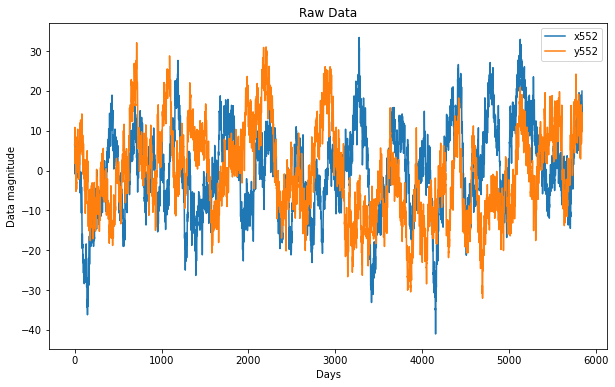

In [3]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x, label='x552')
plt.plot(y, label='y552')
plt.xlabel('Days')
plt.ylabel('Data magnitude')
plt.title('Raw Data')
plt.legend()
plt.show()

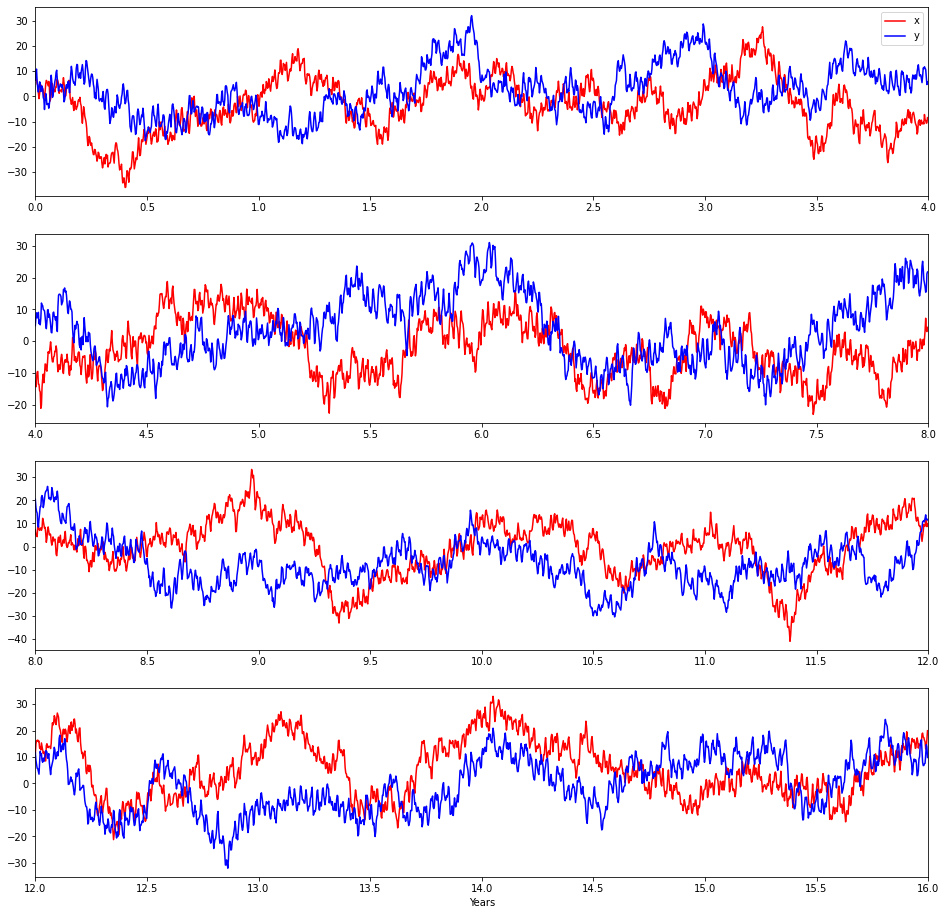

In [4]:
xax = np.linspace(0, nn-1, num=nn) / 365.25
len_chunk = int(nn/4)

x_4 = x.reshape(4, len_chunk)
y_4 = y.reshape(4, len_chunk)
xax_4 = xax.reshape(4, len_chunk)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))
for i, ax in enumerate(axs):
    ax.plot(xax_4[i, :], x_4[i, :], label='x', c='r')
    ax.plot(xax_4[i, :], y_4[i, :], label='y', c='b')
    ax.set_xlim([4*i, 4*(i+1)])
axs[3].set_xlabel('Years')
axs[0].legend(loc=1)
plt.show()

# 2. Show power spectra

## Remove annual cycle

In [5]:
N = 4
t = np.linspace(1, nn, nn) 
days = 365.25
harmonics = np.zeros([N, nn])
coss = (0, 2)
sins = (1, 3)

for i in range(int(N/2)):
    j = 2*i
    k = 2*i+1
    harmonics[j, :] = np.cos((i+1)*2*np.pi/days*t) 
    harmonics[k, :] = np.sin((i+1)*2*np.pi/days*t)

Cx = np.matmul(harmonics, x/nn)
Cy = np.matmul(harmonics, y/nn)
fitx = np.matmul(Cx, harmonics)
fity = np.matmul(Cy, harmonics)

x_removed = x - fitx
y_removed = y - fity

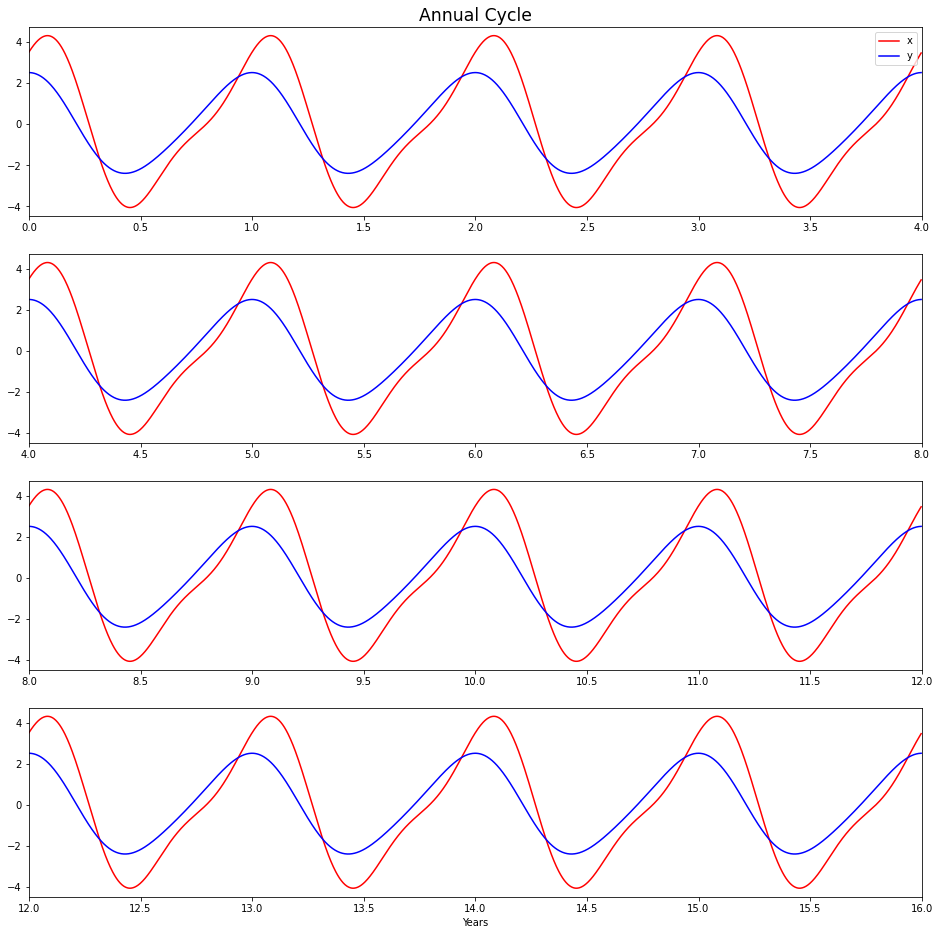

In [6]:
xplt = fitx
yplt = fity

xax = np.linspace(0, nn-1, num=nn) / 365.25
len_chunk = int(nn/4)

x_4 = xplt.reshape(4, len_chunk)
y_4 = yplt.reshape(4, len_chunk)
xax_4 = xax.reshape(4, len_chunk)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))
for i, ax in enumerate(axs):
    ax.plot(xax_4[i, :], x_4[i, :], label='x', c='r')
    ax.plot(xax_4[i, :], y_4[i, :], label='y', c='b')
    ax.set_xlim([4*i, 4*(i+1)])
axs[3].set_xlabel('Years')
axs[0].legend(loc=1)
axs[0].set_title('Annual Cycle', size='xx-large')
plt.show()

## High pass butterworth filter

In [7]:
def filter_data(x, N, Wn, btype):
    Wn = [2*w for w in Wn]  # now as fraction of nyquist frequency
    sos = sig.butter(N, Wn, btype=btype, output='sos')
    filtered = sig.sosfiltfilt(sos, x)
    return filtered

In [8]:
filt_limit = 40  # days

order = 9
filtered_x = filter_data(x_removed, order, [1/filt_limit], btype='highpass')
filtered_y = filter_data(y_removed, order, [1/filt_limit], btype='highpass')

# Used this to examine the ~29 day peak
# filter_band = [1/35, 1/25]
# filtered_x1 = filter_data(x_removed.values, order, filter_band, btype='bandpass')
# filtered_y1 = filter_data(y_removed.values, order, filter_band, btype='bandpass')

## Spectral Analysis

In [9]:
x_sp = filtered_x
y_sp = filtered_y

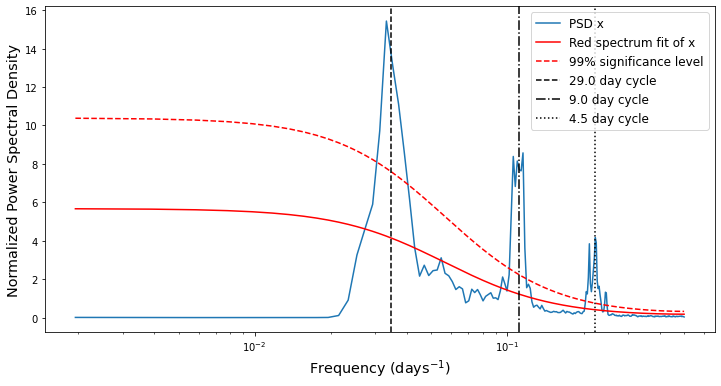

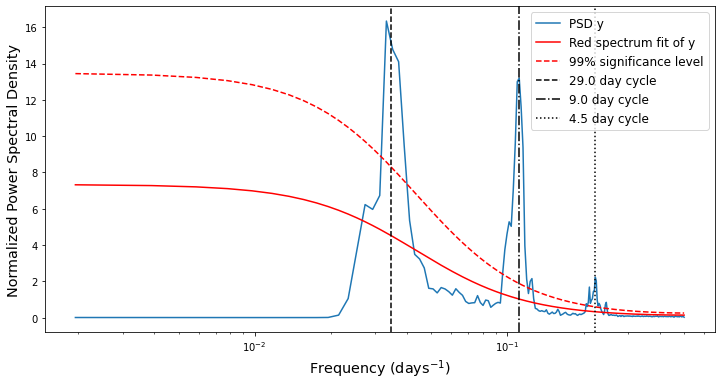

In [10]:
def confidence_limit(x, freqs, spec, nperseg):
    """Adapted from Noah Rosenberg. """
    alpha = pd.Series(x).autocorr(lag=1)
    red_fit = (1-alpha**2)/(1-2*alpha*np.cos(freqs*np.pi*2)+ alpha**2)
    nu = 2*len(x)/nperseg
    nu_0 = len(x)*(1-alpha)/(1+alpha)
    f_crit = f.ppf(q=0.99, dfn=nu, dfd=nu_0)
    return red_fit, red_fit*f_crit

n = 512
nx = n
ny = n
nx2 = nx/2
ny2 = ny/2
freqs_x, pxx = sig.welch(x_sp, window='hamming', nperseg=nx)
freqs_y, pyy = sig.welch(y_sp, window='hamming', nperseg=ny)
pxx = pxx / np.mean(pxx)
pyy = pyy / np.mean(pyy)

# Fit red spectrum
alphax = pd.Series(x_sp).autocorr(lag=1)
alphay = pd.Series(y_sp).autocorr(lag=1)
red_specx, red_99x = confidence_limit(x_sp, freqs_x, pxx, nperseg=nx)
red_specy, red_99y = confidence_limit(y_sp, freqs_y, pyy, nperseg=ny)

# Identify peaks
p1 = 1/29
p2 = 1/9
p3 = 1/4.5

fig = plt.figure(figsize=(12, 6))
plt.semilogx(freqs_x[1:], pxx[1:], label='PSD x')
plt.plot(freqs_x[1:], red_specx[1:], label='Red spectrum fit of x', c='r')
plt.plot(freqs_x[1:], red_99x[1:], label='99% significance level', ls='--', c='r')
plt.axvline(p1, c='k', ls='--', label='{} day cycle'.format(1/p1))
plt.axvline(p2, c='k', ls='-.', label='{} day cycle'.format(1/p2))
plt.axvline(p3, c='k', ls=':', label='{} day cycle'.format(1/p3))
plt.xlabel('Frequency (days$^{-1}$)', size='x-large')
plt.ylabel('Normalized Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.semilogx(freqs_y[1:], pyy[1:], label='PSD y')
plt.plot(freqs_y[1:], red_specy[1:], label='Red spectrum fit of y', c='r')
plt.plot(freqs_y[1:], red_99y[1:], label='99% significance level', ls='--', c='r')
plt.axvline(p1, c='k', ls='--', label='{} day cycle'.format(1/p1))
plt.axvline(p2, c='k', ls='-.', label='{} day cycle'.format(1/p2))
plt.axvline(p3, c='k', ls=':', label='{} day cycle'.format(1/p3))
plt.xlabel('Frequency (days$^{-1}$)', size='x-large')
plt.ylabel('Normalized Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

# 3. Compute cross-spectral analysis

In [11]:
def cohstat(dof, siglev):
    """Adapted to python from Dennis Hartmann's cohstat.m function."""
    f99=[0.99,0.684,0.602,0.536,0.482,0.438,0.401,0.342,0.264,0.215,0.175,0.147,0.112,0.075,0.057,0.045,0.023,0.002]
    f90=[0.901,0.437,0.370,0.319,0.280,0.250,0.226,0.189,0.142,0.112,0.091,0.076,0.057,0.038,0.029,0.023,0.011,0.001]
    f95=[0.951,0.527,0.450,0.393,0.348,0.312,0.283,0.238,0.181,0.146,0.118,0.098,0.074,0.050,0.037,0.030,0.015,0.001]
    n=[2,5,6,7,8,9,10,12,16,20,25,30,40,60,80,100,200,1000000]

    if (siglev > .95):
        f = f99
    else:
        f= f95

    for i in range(len(n)):
        if (dof <= n[i]):
            if i == 0:
                cohstat = f[0]
                return cohstat
            cohstat = f[i]-(n[i]-dof)*(f[i]-f[i-1])/(n[i]-n[i-1])
            return cohstat
        else:
            cohstat = f[17]
    return cohstat

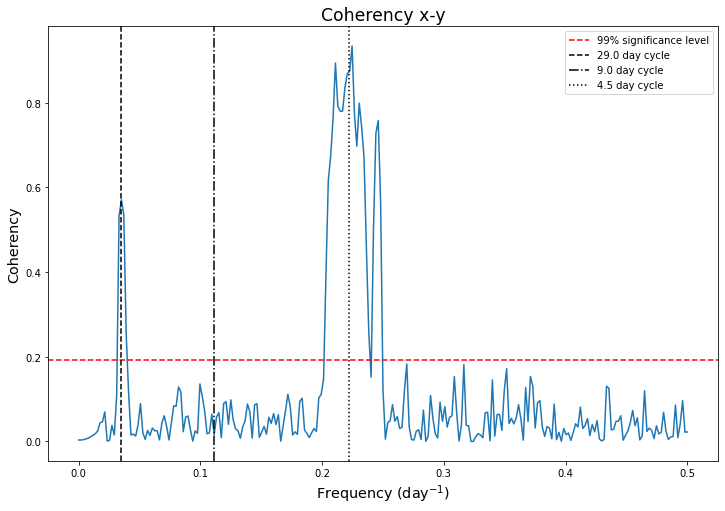

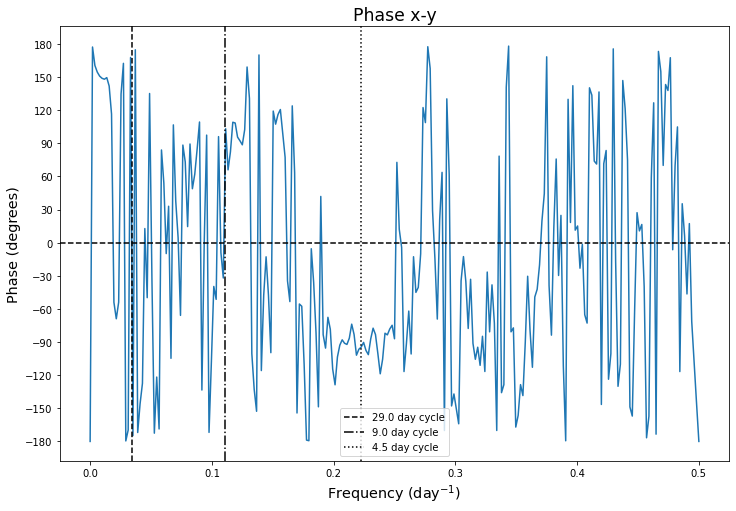

In [12]:
f1, Pxy = sig.csd(x_sp, y_sp, window='hamming', nperseg=n)  # cross power spectrum density
#Cxy = np.sqrt(np.real(Pxy)*np.real(Pxy))  # co-spectrum amplitude
#Qxy = np.sqrt(np.imag(Pxy)*np.imag(Pxy))  #quadrature spectrum amplitude
#Crxy = np.sqrt(Pxy*np.conj(Pxy))  # cross-spectrum amplitude
f2, Cohxy = sig.coherence(x_sp, y_sp, window='hamming', nperseg=n)  # coherency
Phxy = np.arctan2(-np.imag(Pxy), np.real(Pxy))*180/np.pi  # phase in degrees

# find significance level
siglev = 0.99
dof = 2*len(x)/n
cohcrit = cohstat(dof, siglev)

# Identify peaks
p1 = 1/29
p2 = 1/9
p3 = 1/4.5

fig = plt.figure(figsize=(12, 8))
plt.plot(f2, Cohxy)
plt.axhline(cohcrit, c='r', ls='--', label='99% significance level')
plt.axvline(p1, c='k', ls='--', label='{} day cycle'.format(1/p1))
plt.axvline(p2, c='k', ls='-.', label='{} day cycle'.format(1/p2))
plt.axvline(p3, c='k', ls=':', label='{} day cycle'.format(1/p3))
plt.title('Coherency x-y', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Coherency', size='x-large')
plt.legend()
plt.show()

fig1 = plt.figure(figsize=(12, 8))
plt.plot(f2, Phxy)
plt.axhline(0, c='k', ls='--')
plt.axvline(p1, c='k', ls='--', label='{} day cycle'.format(1/p1))
plt.axvline(p2, c='k', ls='-.', label='{} day cycle'.format(1/p2))
plt.axvline(p3, c='k', ls=':', label='{} day cycle'.format(1/p3))
plt.title('Phase x-y', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Phase (degrees)', size='x-large')
plt.yticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.legend()
plt.show()